In [1]:
!pwd
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/tf_work


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

# 事前トレーニング済みのConvNetによる転移学習
- https://www.tensorflow.org/tutorials/images/transfer_learning

Epoch 1/5
291/291 [==============================] - 42s 144ms/step - loss: 0.4033 - accuracy: 0.8006 - val_loss: 0.2768 - val_accuracy: 0.8828
Epoch 2/5
291/291 [==============================] - 34s 118ms/step - loss: 0.2392 - accuracy: 0.8987 - val_loss: 0.2149 - val_accuracy: 0.9091
Epoch 3/5
291/291 [==============================] - 34s 117ms/step - loss: 0.1995 - accuracy: 0.9153 - val_loss: 0.1911 - val_accuracy: 0.9267
Epoch 4/5
291/291 [==============================] - 32s 109ms/step - loss: 0.1809 - accuracy: 0.9222 - val_loss: 0.1780 - val_accuracy: 0.9328
Epoch 5/5
291/291 [==============================] - 33s 113ms/step - loss: 0.1702 - accuracy: 0.9267 - val_loss: 0.1682 - val_accuracy: 0.9310


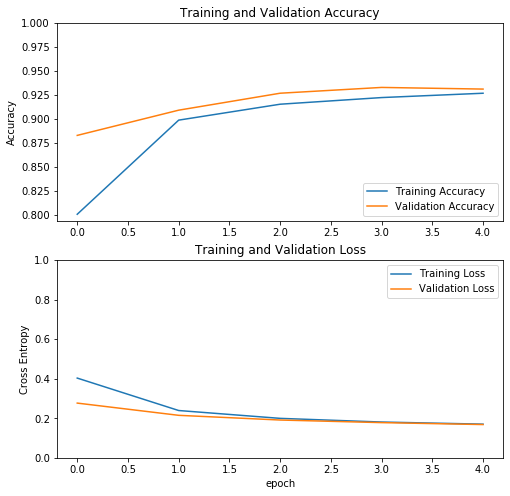

20/20 - 2s - loss: 0.1653 - accuracy: 0.9414
0.16526422053575515 0.94140625


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()  # Tqdmプログレスバーを無効にする

# TensorFlow Datasetsを使用して、猫と犬のデータセットを読み込みます
#(raw_train, raw_validation, raw_test), metadata = tfds.load(
#    'cats_vs_dogs',
#    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
#    with_info=True,
#    as_supervised=True,
#)

IMG_SIZE = 160 # All images will be resized to 160x160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32 * 2
SHUFFLE_BUFFER_SIZE = 1000  # ランダム化する要素の単位 https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle


class DataSet:

    @staticmethod
    def format_example(image, label, img_size=IMG_SIZE):
        """ データ前処理 """
        image = tf.cast(image, tf.float32)
        image = (image/127.5) - 1
        image = tf.image.resize(image, (img_size, img_size))
        return image, label
    
    @staticmethod
    def load_cats_and_dogs_dataset(batch_size=BATCH_SIZE):
        """ 犬猫画像ロードしてバッチに分ける """
        # TensorFlow Datasetsを使用して、猫と犬のデータセットを読み込み
        # tf 2.0では上の書き方ではエラーになる
        # https://stackoverflow.com/questions/59959438/keyerror-invalid-split-train80-available-splits-are-train
        (raw_train, raw_validation, raw_test), metadata = tfds.load(
            'cats_vs_dogs',
            split=[
                tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
                tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
                tfds.Split.TRAIN.subsplit(tfds.percent[90:])
            ], 
            with_info=True,
            as_supervised=True,
        )
        
        # mapメソッドを使用して、この関数をデータセット内の各アイテムに適用
        train = raw_train.map(DataSet().format_example)
        validation = raw_validation.map(DataSet().format_example)
        test = raw_test.map(DataSet().format_example)
        
        # データをシャッフルしてバッチ処理
        train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
        validation_batches = validation.batch(batch_size)
        test_batches = test.batch(batch_size)
        
        return train_batches, validation_batches, test_batches
    
    
class Model:
    
    @staticmethod
    def net_like_vgg16(input_shape=IMG_SHAPE, n_class=1):
        """ vgg16っぽいモデル構築 """
        # pre-trained model
        base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
        # finetuning
        base_model.trainable = False
        # pooling+出力層
        x = base_model.output
        pooling = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(n_class)(pooling)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
        return model
            
    @staticmethod
    def train(model, train_batches, validation_batches, 
              base_learning_rate=0.01, 
              initial_epochs=5):
        """ モデルでtrain """
        # コンパイル
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
                      metrics=['accuracy'])
        # train
        history = model.fit(train_batches,
                            epochs=initial_epochs,
                            validation_data=validation_batches)
        
        return model, history
    
    @staticmethod
    def plot_hist(history):
        """ train結果plot """
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()
    
    def predict(model, imag_path=r"D:\iPhone_pictures\2015-05\IMG_5636.JPG"):
        """ 予測 """
        DataSet().format_example
        image = tf.cast(image, tf.float32)
        image = (image/127.5) - 1
        image = tf.image.resize(image, (img_size, img_size))
        
        
    
if __name__ == '__main__':
    
    train_batches, validation_batches, test_batches = DataSet().load_cats_and_dogs_dataset()
    # print(train_batches)
    # print(validation_batches)
    # print(test_batches)

    model = Model().net_like_vgg16()
    trained_model, history = Model().train(model, train_batches, validation_batches)
    Model().plot_hist(history)
    
    # モデルの評価
    test_loss, test_acc = trained_model.evaluate(test_batches, steps=20, verbose=2)
    print(test_loss, test_acc)
